# Calculo de las metricas de un json

In [1]:
class Game():
    """Almacena informacion sobre una partida:
    - When the level starts and ends and its lenght
    - The event result
    - Player deaths during this level
    """
    def __init__(self, id, tsStart):
        """Constructor
        """
        self.id = id
        self.tsLevelStart = tsStart
        self.levelLengthMs = 0
        self.shields = 0    
        self.deaths = 0

    def addDeath(self):
        self.deaths += 1
    
    def addShield(self):
        self.shields += 1

    def calculateTime (self, endTime):
        self.levelLengthMs = endTime - self.tsLevelStart


### Importacion de las librerias necesarias

In [2]:
import json
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Lectura del documento

In [3]:
# Ruta del archivo con los datos obtenidos por el "Tracking system"
file_path = './RESULT.json'

In [4]:
# Abrir el archivo json y cargarlo en la variable data
with open(file_path) as f:
    data = json.load(f)

# Se ordena la información del documento en base el timestamp
sorted_data = sorted(data, key=lambda x: x['timestamp'])

### Duraciones de cada sesion

In [5]:
# Longitud de cada sesion en milisegundos
sessionLengthMs = []
for currentEvent in sorted_data:
    if currentEvent['typeEvent'] == "LoginEvent":
        tsSessionStart = currentEvent['timestamp']
        r = re.search(r'\d+', tsSessionStart)
        numeric_tsSessionStart = int(r.group())
    if currentEvent['typeEvent'] == "LogoutEvent":
        tsSessionEnd = currentEvent['timestamp']
        r = re.search(r'\d+', tsSessionEnd)
        numeric_tsSessionEnd = int(r.group())
        sessionLengthMs.append(numeric_tsSessionEnd- numeric_tsSessionStart)

s = pd.Series(sessionLengthMs)
#print(s.describe())
s

0    379089
dtype: int64

### Calculo de las metricas

Las metricas a tener en cuenta son:
- Numero de muertes por partida
- Numero de veces que se pierde el escudo por nivel
- Tiempo en complentar una partida

Adicionalmete se ha añadido las muertes totales y numero de perdidas de escudo por sesion

In [6]:
game_list = []
index_game = 0
sesion = 0
# Indice de eventos
index = 0
# Numero total de eventos
num_events = len(sorted_data)
# Lista de muertes para hacer la media
death_list = []
# Lista de escudos para hacer la media
shield_list = []

level = 0
shields_per_level = 0

In [7]:
duration = []
deathCount = []

def parseEvent(event):
    global index_game
    global game_list
    global sesion
    global death_list
    global shield_list
    global level
    global shields_per_level
    if event['typeEvent'] == "LoginEvent":
        print("\nInicio de sesion: ", sesion)
    elif event['typeEvent'] == "LogoutEvent":
        shields = 0
        deaths = 0
        for game in game_list:
            shields += game.shields
            deaths += game.deaths
            death_list.append(game.deaths)
            shield_list.append(game.shields)
        print("Perdidas de escudo en total: ", shields, "\nMuertes en total: ", deaths)
        print("\nFin de sesion: ", sesion)
        sesion += 1
    # Empieza la partida
    elif event['typeEvent'] == "StartGameEvent":
        r = re.search(r'\d+', event['timestamp'])
        #game_list.insert(index_game, Game(event["idLevel"], int(r.group())))
        game_list.append(Game(event["idLevel"], int(r.group())))
        shields_per_level = 0
        print("\nPartida: ", index_game, )
    # Acaba la partida
    elif event['typeEvent'] == "EndGameEvent":
        r = re.search(r'\d+', event['timestamp'])
        tsEndTime = int(r.group())
        game_list[index_game].calculateTime(tsEndTime)
        duration.append(game_list[index_game].levelLengthMs)

        print("  Duración: ", game_list[index_game].levelLengthMs, "\n  Muertes: ", game_list[index_game].deaths, "\n  Perdidas de escudo: ", game_list[index_game].shields)
        print("  Nivel: ", level, ", escudos perdidos: ", shields_per_level)
        level = 0
        index_game += 1
    elif event['typeEvent'] == "LoseShieldEvent":
        game_list[index_game].addShield()
        shields_per_level +=1 
    elif event['typeEvent'] == "DeathEvent":
        game_list[index_game].addDeath()
        print("  Nivel: ", level, ", escudos perdidos: ", shields_per_level)
        shields_per_level = 0
        level +=1 
    return  True

In [8]:
# Recorro todos los eventos generados
while index < num_events:
    currentEvent = sorted_data[index]
    consumeEvent = parseEvent(currentEvent)
    index += 1


Inicio de sesion:  0

Partida:  0
  Duración:  105530 
  Muertes:  0 
  Perdidas de escudo:  1
  Nivel:  0 , escudos perdidos:  1

Partida:  1
  Duración:  98677 
  Muertes:  0 
  Perdidas de escudo:  3
  Nivel:  0 , escudos perdidos:  3

Partida:  2
  Nivel:  0 , escudos perdidos:  1
  Nivel:  1 , escudos perdidos:  1
  Nivel:  2 , escudos perdidos:  1
  Duración:  141530 
  Muertes:  3 
  Perdidas de escudo:  3
  Nivel:  3 , escudos perdidos:  0
Perdidas de escudo en total:  7 
Muertes en total:  3

Fin de sesion:  0


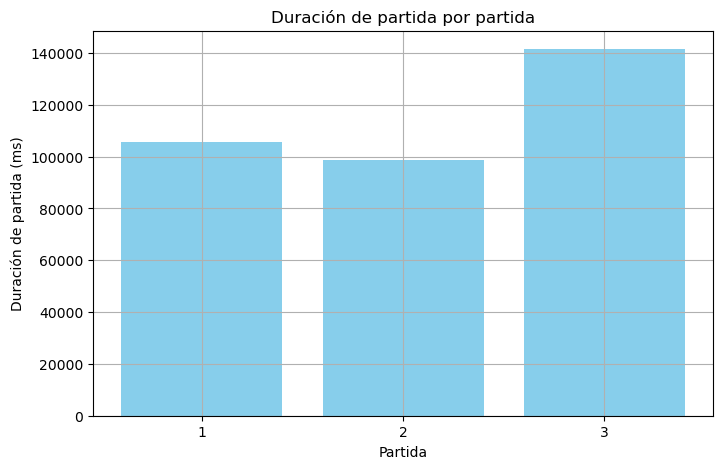

In [9]:
#Grafico de la Duración de cada partida
plt.figure(figsize=(8, 5))
plt.bar(range(len(duration)), duration, color='skyblue')
plt.xlabel('Partida')
plt.ylabel('Duración de partida (ms)')
plt.title('Duración de partida por partida')
plt.xticks(range(len(duration)), range(1, len(duration) + 1))
plt.grid(True)
plt.show()

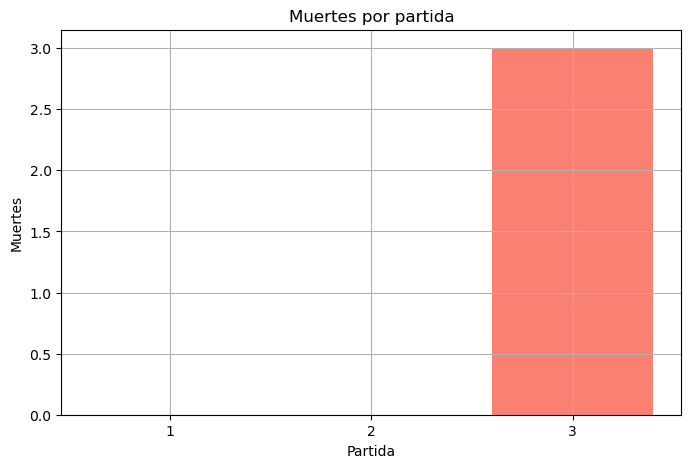

In [10]:
plt.figure(figsize=(8, 5))
plt.bar(range(len(death_list)), death_list, color='salmon')
plt.xlabel('Partida')
plt.ylabel('Muertes')
plt.title('Muertes por partida')
plt.xticks(range(len(death_list)), range(1, len(death_list) + 1))
plt.grid(True)
plt.show()

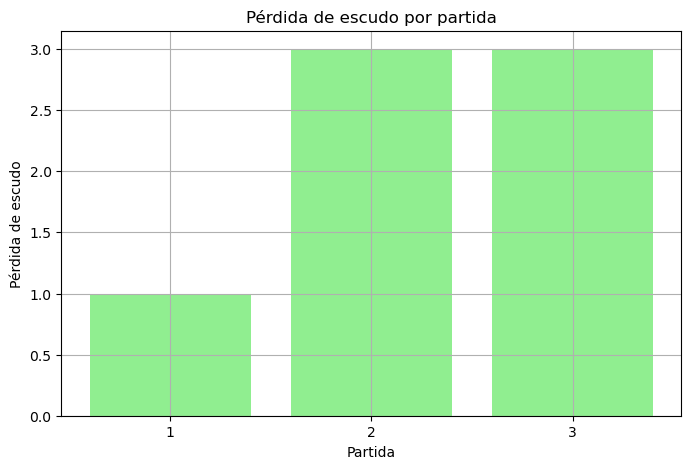

In [11]:
plt.figure(figsize=(8, 5))
plt.bar(range(len(shield_list)), shield_list, color='lightgreen')
plt.xlabel('Partida')
plt.ylabel('Pérdida de escudo')
plt.title('Pérdida de escudo por partida')
plt.xticks(range(len(shield_list)), range(1, len(shield_list) + 1))
plt.grid(True)
plt.show()

### Medias

Esto implica todas las sesiones y partidas, es la media total

In [14]:
mean = np.mean(death_list)
print("\nMedia de muertes:", round(mean, 2))
mean = np.mean(shield_list)
print("Media de perdidas de escudo:", round(mean, 2)) 
mean = np.mean(duration)
print("Media de la duracion de las partidas:", round(mean, 2))  


SyntaxError: invalid decimal literal (2351144090.py, line 2)